# Homework: Learning Audio Representations with Self-Supervision

In this homework, we will consolidate the knowledge gained during the seminar and further explore methods for self-supervised learning of audio representations.
During the seminar, we implemented and trained a model based on contrastive learning (InfoNCE). Now, we will extend this work by implementing non-contrastive learning (NCL) approaches and comparing them with previously studied methods.

We will examine how different training paradigms — supervised, contrastive, and non-contrastive — affect the quality of learned embeddings and the stability of the training process


## Multi-Format Contrastive Learning of Audio Representations(Paper from seminar)

The core idea of this approach is to learn robust audio embeddings by contrasting
different *formats* (or views) of the same audio sample.  
For example, one branch may encode the **raw waveform (1D)** while another encodes
its **spectrogram (2D)**.  

By applying a contrastive loss (InfoNCE), the model is trained to:
- **Pull together** embeddings from different formats of the same audio,
- **Push apart** embeddings from different audio samples.  

This multi-format setup encourages the encoder to capture **shared semantic content**
across input representations, leading to more general and transferable audio features.

[paper1](https://arxiv.org/pdf/2103.06508), [paper2](https://arxiv.org/pdf/2010.09542)

[github source](https://github.com/HondamunigePrasannaSilva/CLAR?tab=readme-ov-file)

## AudioSet

Dataset with 10 numbers pronounced
```
!git clone https://github.com/soerenab/AudioMNIST.git
```



In [ ]:
!git clone https://github.com/soerenab/AudioMNIST.git

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30137, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 30137 (delta 9), reused 4 (delta 1), pack-reused 30119 (from 1)
Receiving objects: 100% (30137/30137), 944.54 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (30018/30018), done.


In [ ]:
import os
import random
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from IPython.display import Audio
from pathlib import Path
from omegaconf import DictConfig

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm.notebook import tqdm
from torch.utils.data import Subset, DataLoader, Dataset
from torchaudio import transforms
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore", module="torchaudio._backend")

plt.rcParams.update({'font.size': 14})

In [ ]:
#check for cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available device:", device)

Available device: cuda


In [ ]:
root = '/content/AudioMNIST/data'

### Data Processing


In [ ]:
class AudioMNISTDataset(Dataset):
  def __init__(self, root, sr=16000):
        self.root = root
        self.sr = sr
        self.items = self.list_wavs_and_labels(root)

  def __len__(self):
      return len(self.items)

  def list_wavs_and_labels(self, root: str):
      base = Path(root)
      speakers = sorted([p for p in base.iterdir() if p.is_dir()])
      items = []
      for sp in speakers:
          for wav in sorted(sp.glob("**/*.wav")):
              # filename e.g., "9_10_0_0_1.wav" (digit_speaker_..)
              name = wav.stem.split("_")
              digit = int(name[0])
              speaker_id = sp.name
              items.append((str(wav), digit, speaker_id))
      return items

  def load_wav(self, path):
      wav, sr = torchaudio.load(path)  # [C, T]
      if sr != self.sr:
          wav = torchaudio.functional.resample(wav, sr, self.sr)
      wav = wav.mean(dim=0, keepdim=True)  # mono [1, T]
      return wav

  def __getitem__(self, idx):
      path, label, speaker = self.items[idx]
      wav = self.load_wav(path)

      return wav, label

def collate(batch):
    wavs, labels = zip(*batch)
    wavs = nn.utils.rnn.pad_sequence([w.squeeze(0).t() for w in wavs], batch_first=True)  # [B, Tw, 1]? we transposed; fix:
    wavs = nn.utils.rnn.pad_sequence([w.squeeze(0) for w in wavs], batch_first=True)  # [B, T]
    labels = torch.tensor(labels, dtype=torch.long)
    return wavs, labels


# Ensure data loading correctly
_test_dataset = AudioMNISTDataset(root)
_test_dataset[0]

(tensor([[0.0003, 0.0005, 0.0004,  ..., 0.0005, 0.0005, 0.0006]]), 0)

In [ ]:
def split_indices_by_speaker(dataset: AudioMNISTDataset, test_speakers: set):
    train_idxs = []
    test_idxs = []
    for idx, (_, _, spk) in enumerate(dataset.items):
        if spk in test_speakers:
            test_idxs.append(idx)
        else:
            train_idxs.append(idx)
    return train_idxs, test_idxs


# Split dataset by speakers
NUM_TEST_SPEAKERS = 12
full_ds = AudioMNISTDataset(root=root)
all_speakers = sorted({spk for (_, _, spk) in full_ds.items})
valid_speakers = set(all_speakers[-NUM_TEST_SPEAKERS:])
train_idxs, valid_idxs = split_indices_by_speaker(full_ds, valid_speakers)
train_ds = Subset(full_ds, train_idxs)
valid_ds = Subset(full_ds, valid_idxs)

In [ ]:
# @title CreateResNet
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None,stride=1):
        super(block, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.identity_downsample = identity_downsample
        self.relu = nn.ReLU()


    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)

        return x

class ResNet1D(nn.Module):
    # Resnet 18 [2, 2, 2, 2]
    def __init__(self, block):
        super(ResNet1D, self).__init__()
        # for resnet18
        layers = [2, 2, 2, 2]
        self.expansion = 1

        self.in_channels = 64
        self.conv1 = nn.Conv1d(1, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(self.in_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)


        self.layer1 = self._make_layer(block, layers[0], 64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], 128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], 256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(output_size=1)


        # size after avgpool = [32, 512, 1]

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        #x = x.reshape(x.shape[0], -1)
        #x = self.fc(x)

        return x



    def _make_layer(self, block, num_residual_block, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1:
            identity_downsample = nn.Sequential(nn.Conv1d(self.in_channels,
                                                out_channels*self.expansion,
                                                kernel_size=1,
                                                stride=stride,
                                                bias=False),
                                                nn.BatchNorm1d(out_channels*self.expansion),
                                                )
        layers.append(
            block(self.in_channels,out_channels, identity_downsample, stride)
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, num_residual_block):
            layers.append(block(self.in_channels,out_channels ))

        return nn.Sequential(*layers)



def CreateResNet1D():
    return ResNet1D(block)



class block_resnet2d(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None,stride=1):
        super(block_resnet2d, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.identity_downsample = identity_downsample
        self.relu = nn.ReLU()


    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)

        return x

class ResNet(nn.Module):
    # Resnet 18 [2, 2, 2, 2]
    def __init__(self, block, image_channels):
        super(ResNet, self).__init__()
        # for resnet18
        layers = [2, 2, 2, 2]
        self.expansion = 1

        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        self.layer1 = self._make_layer(block, layers[0], 64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], 128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], 256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))


    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        return x



    def _make_layer(self, block, num_residual_block, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels,
                                                out_channels*self.expansion,
                                                kernel_size=1,
                                                stride=stride,
                                                bias=False),
                                                nn.BatchNorm2d(out_channels*self.expansion),
                                                )
        layers.append(
            block(self.in_channels,out_channels, identity_downsample, stride)
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, num_residual_block):
            layers.append(block(self.in_channels,out_channels ))

        return nn.Sequential(*layers)



def CreateResNet2D(img_channels=1):
    return ResNet(block_resnet2d, image_channels=img_channels)

In [ ]:
# @title Augmentations
def pitchshift(audio, SAMPLE_RATE=16000, shift = 2):
    """
    Pitch Shift (PS): randomly raises or lowers the pitch of the audio signal.\n
    Based on experimental observation,we found the range of pitch shifts that main-tained\n
    the overall coherency of the input audio was in the range [-15, 15] semitones.

    Attributes:
    - :param audio: audio tensor
    - :param SAMPLE_RATE: Sample rate, default=16000
    - :param shift: Pitch shift
    - :return: describe what it returns
    """
    assert audio != None, "audio should not be None"
    transform = transforms.PitchShift(sample_rate=SAMPLE_RATE, n_steps=shift).to(audio.device)
    waveform_shift = transform(audio)
    return waveform_shift


def fade_in_out(audio):
    """
    Fade in/out (FD): gradually increases/decreases the intensity of the audio in the\n
    beginning/end of the audio signal.\n
    The degree of the fade was either linear, logarithmic or exponential (applied\n
    with uniform probability of 1/3). The size of the fade for either side of the\n
    audio signal could at maximum reach half of the audio signal. The size of the\n
    fade was another random parameter picked for each sample.
    """
    assert audio != None, "audio should not be None"
    _fade_shape = ['linear', 'logarithmic', 'exponential']
    _fade_size = [i for i in range(1, int(audio.shape[2]/2))]

    transform = transforms.Fade(fade_in_len=random.choice(_fade_size), fade_out_len=random.choice(_fade_size), fade_shape=random.choice(_fade_shape)).to(audio.device) # Move transform to device
    waveform_fade_in_out = transform(audio)
    return waveform_fade_in_out

def add_white_noise_(signal, noise_level):
    """
    Noise Injection: mix the audio signal with random white, brown and pink noise.\n
    In our implementation, the intensity of the noise signal was randomly selected based\n
    on the strength of signal-to-noise ratio. Applied white, brown, or pink depending\n
    on an additional random parameter sampled from uniform distribution (Mixed Noise).
    """
    noise = torch.randn_like(signal)*torch.std(signal) * noise_level
    noisy_signal = signal + noise
    return noisy_signal


def timemasking(waveform, batch_size, sample_rate=16000):
    """
    Time masking:given an audio signal, in this transformation we randomly select a small\n
    segment of the full signal and set the signal values in that segment to normal noise or a\n
    constant value. In our implementation, we not only randomly selected the location of the\n
    masked segment but also we randomly selected the size of the segment. The size of the \n
    masked segment was set to maximally be 1/8 of the input signal.
    """
    bs, ch, length = waveform.shape
    mask_len = length // 8
    augmented = waveform.clone()
    for i in range(bs):
        start = random.randint(0, length - mask_len)
        augmented[i, :, start:start + mask_len] = 0.0
    return augmented

## Task 1(2 points)

Impelment strightforward classifier training based on waveforms or spectrogram(use models from seminar). Train it in supervised manner and compute accuracy

In [ ]:
hyperparameters = {
        'LR': 3e-4,
        'WEIGHT_DECAY': 1e-6,
        'B1':0.9,
        'B2':0.999,
        'EPOCHS': 5,
        'BATCH_SIZE': 128,
        'IMG_CHANNEL': 1,
        'CLASSES': 10,
        'EVAL_BATCH':128,
        'EVAL_EPOCHS':1,
        'MODEL_TITLE': 'contrastive'
}
config = DictConfig(hyperparameters)

train_loader = DataLoader(train_ds, batch_size=config.BATCH_SIZE, shuffle=True, collate_fn=collate)
val_loader  = DataLoader(valid_ds,  batch_size=config.EVAL_BATCH, shuffle=False, collate_fn=collate)

In [ ]:
class ClassifiierNet_1D(nn.Module):
    def __init__(self, num_classes = 35):
        super().__init__()
        self.resnet_1D = CreateResNet1D()

        self.output = nn.Linear(512, num_classes)

    def forward(self, input_audio):
        audio = self.resnet_1D(input_audio)
        audio = audio.squeeze()

        logits_audio = self.output(audio)

        return logits_audio

class ClassifiierNet_2D(nn.Module):
    def __init__(self, num_classes = 35):
        super().__init__()
        self.resnet_2D = CreateResNet2D()

        self.output = nn.Linear(512, num_classes)

    def forward(self, input_spectogram):
        spectogram = self.resnet_2D(input_spectogram)
        spectogram = spectogram.squeeze()

        logits_spectogram = self.output(spectogram)

        return logits_spectogram


In [ ]:
def create_input(audio, mel_transform, melspectrogram = False, augmentation = False, sr=16000):
  if augmentation:
    audio = audio.unsqueeze(1)
    audio = fade_in_out(audio)
    audio = timemasking(audio, audio.shape[0])
    audio = pitchshift(audio)
    audio = add_white_noise_(audio, 0.5)
    audio = audio.squeeze(1)

  if melspectrogram:
     mel_transform = mel_transform.to(audio.device)
     mel_specs_list = []
     for waw in audio:
       mel_specs = mel_transform(waw.unsqueeze(0))
       mel_db = torchaudio.transforms.AmplitudeToDB(top_db=torch.max(waw))(mel_specs)
       mel_specs_list.append(mel_db.squeeze(0))

     return torch.stack(mel_specs_list).unsqueeze(1)
  return audio.unsqueeze(1)

In [ ]:
def train_loop(model, optimizer, criterion, train_loader, val_loader, num_epochs, mel_transform, melspectrogram = False, augmentation = True):
    model.to(device)
    losses = []
    accuracies = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for waw_batch, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - Training"):
            waw_batch, labels_batch = waw_batch.to(device), labels_batch.to(device)
            input_batch = create_input(waw_batch, mel_transform, melspectrogram=melspectrogram, augmentation=augmentation)

            optimizer.zero_grad()
            logits = model(input_batch)
            loss = criterion(logits, labels_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)
        print(f"Epoch {epoch}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

        if epoch == num_epochs:
          model.eval()
          correct = 0
          total = 0
          with torch.no_grad():
              for waw_batch, labels_batch in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} - Validation"):
                  waw_batch, labels_batch = waw_batch.to(device), labels_batch.to(device)
                  input_batch = create_input(waw_batch, mel_transform, melspectrogram=melspectrogram, augmentation=False)

                  logits = model(input_batch)
                  _, predicted = torch.max(logits.data, 1)
                  total += labels_batch.size(0)
                  correct += (predicted == labels_batch).sum().item()

          epoch_accuracy = 100 * correct / total
          accuracies.append(epoch_accuracy)
          print(f"Epoch {epoch}/{num_epochs}, Validation Accuracy: {epoch_accuracy:.2f}%")

    return losses, accuracies

In [ ]:
model = ClassifiierNet_1D(num_classes=10)
optimizer = optim.Adam(model.parameters(), lr=config.LR, betas=(config.B1, config.B2), weight_decay=config.WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

In [ ]:
torch.cuda.empty_cache()
losses_1d, accuracies_1d = train_loop(model, optimizer, criterion, train_loader, val_loader, num_epochs=config.EPOCHS, mel_transform=None, melspectrogram=False, augmentation=True)

Epoch 1/5 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/5, Training Loss: 0.0093


Epoch 2/5 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/5, Training Loss: 0.0063


Epoch 3/5 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3/5, Training Loss: 0.0056


Epoch 4/5 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4/5, Training Loss: 0.0052


Epoch 5/5 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5/5, Training Loss: 0.0050


Epoch 5/5 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/5, Validation Accuracy: 37.47%


In [ ]:
model = ClassifiierNet_2D(num_classes=10)
optimizer = optim.Adam(model.parameters(), lr=config.LR, betas=(config.B1, config.B2), weight_decay=config.WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()
mel_transform = T.MelSpectrogram(sample_rate=16000, n_fft=2048, hop_length=128, mel_scale="slaney", n_mels=128, f_min=40, f_max=8000).to(device)

In [ ]:
torch.cuda.empty_cache()
losses_2d, accuracies_2d = train_loop(model, optimizer, criterion, train_loader, val_loader, num_epochs=3, mel_transform=mel_transform, melspectrogram=True, augmentation=True)

Epoch 1/3 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.0180


Epoch 2/3 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/3, Training Loss: 0.0179


Epoch 3/3 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3/3, Training Loss: 0.0179


Epoch 3/3 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/3, Validation Accuracy: 11.50%


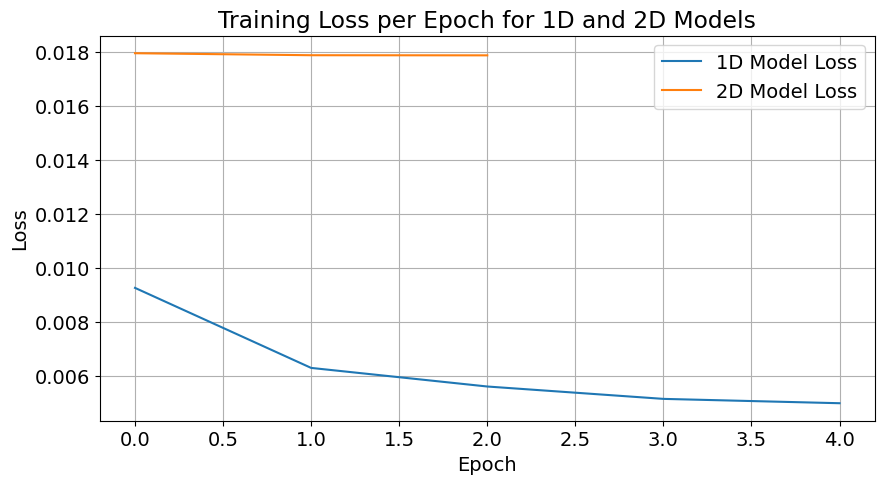

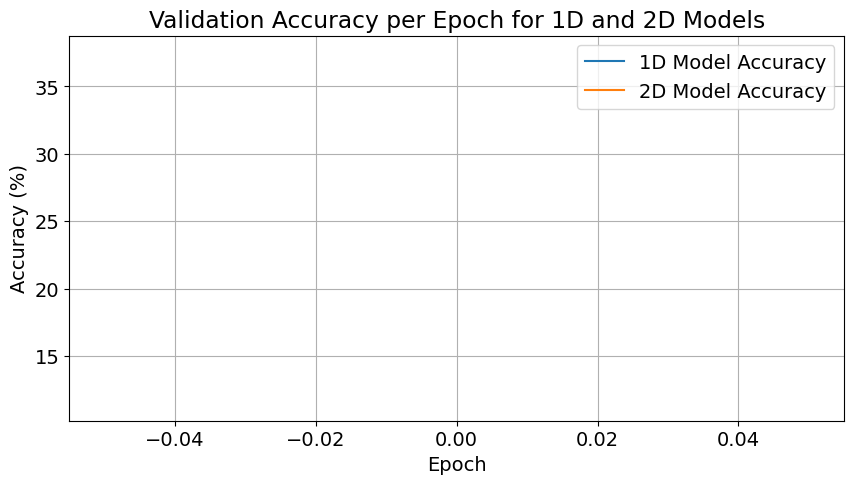

In [ ]:
# Plotting losses
plt.figure(figsize=(10, 5))
plt.plot(losses_1d, label='1D Model Loss')
plt.plot(losses_2d, label='2D Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch for 1D and 2D Models')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracies
plt.figure(figsize=(10, 5))
plt.plot(accuracies_1d, label='1D Model Accuracy')
plt.plot(accuracies_2d, label='2D Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy per Epoch for 1D and 2D Models')
plt.legend()
plt.grid(True)
plt.show()

Я не туда поместил вычисление accuracy и вместо списка получил значение(

пересчитывать не стал, на эту работу потратил адское количество времени, а помимо DLS еще есть чем заняться.

## Task 2(2 points)

Train the Multi-Format Contrastive Learning of Audio Representations model (implemented during the seminar) until convergence. Plot the loss and accuracy curves to verify that the training process has stabilized.

In [ ]:
# @title ContrastiveLoss
def device_as(t1, t2):
   return t1.to(t2.device)

class ContrastiveLoss(nn.Module):
  def __init__(self, temperature=0.5):
    super().__init__()
    self.temperature = temperature

  def calc_similarity_batch(self, a, b):
    rep = torch.cat([a,b])
    return F.cosine_similarity(rep.unsqueeze(1), rep.unsqueeze(0), dim=2)

  def forward(self, proj_1, proj_2):
    batch_size = proj_1.shape[0]
    z_i = F.normalize(proj_1, p=2, dim=1)
    z_j = F.normalize(proj_2, p=2, dim=1)

    similarity_matrix = self.calc_similarity_batch(z_i, z_j)

    #######
    #aa#ab#
    #######
    #ba#bb#
    #######

    sim_ij = torch.diag(similarity_matrix, batch_size)
    sim_ji = torch.diag(similarity_matrix, -batch_size)

    positives = torch.cat([sim_ij, sim_ji])

    nominator = torch.exp(positives / self.temperature)

    mask = (~torch.eye(batch_size*2, batch_size*2).bool()).float()
    mask = device_as(mask, similarity_matrix)

    denominator = mask * torch.exp(similarity_matrix / self.temperature)
    all_losses = -torch.log(nominator / torch.sum(denominator))
    loss = torch.sum(all_losses) / (2*batch_size)

    return loss


In [ ]:
# @title LogMelSpectrogram
class LogMelSpectrogram(T.MelSpectrogram):
    def __init__(self, eps=1e-8, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def forward(self, waveform):
        return (super().forward(waveform) + self.eps).log()

In [ ]:
# @title implementation Net
class Net(nn.Module):

    def __init__(self, img_channels = 1, num_classes = 35):
        super(Net, self).__init__()
        ####################### ENCODER ###################################
        self.resnet_1D = CreateResNet1D()
        self.resnet_2D = CreateResNet2D(img_channels=img_channels)

        self.output = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

        ####################################################################

    def forward(self, input_spectogram, input_audio):
        """
            resnet2d and resnet1d output is [BS, 512, 1, 1]
            Output:
                - audio_emb, specs_emb used for contrastive loss
                - audio, spectograms used for Evaluation layer
                - output used for semi supervised - cross entropy
        """

        audio = self.resnet_1D(input_audio)
        audio = audio.squeeze()
        spectograms = self.resnet_2D(input_spectogram)
        spectograms = spectograms.squeeze()

        audio_emb = self.output(audio)
        specs_emb = self.output(spectograms)

        return audio_emb, specs_emb, audio, spectograms


class EvaluationHead(nn.Module):
    """
    Linear classifier head
    """
    def __init__(self, num_classes = 35):
        super(EvaluationHead, self).__init__()

        self.evaluation = nn.Sequential(
                    nn.Linear(512,num_classes)
        )

    def forward(self,x):
        x = self.evaluation(x)
        return x

In [ ]:
# @title train loop

def create(config):

  # Create model
  model = Net(img_channels=config.IMG_CHANNEL, num_classes = config.CLASSES).to(device)

  # Define the constrastive loss
  loss = ContrastiveLoss()

  #Define Melspectogram and STFT (Magnitude and Phase)
  mel_transform = LogMelSpectrogram(sample_rate=16000, n_fft=2048, hop_length=128, n_mels=128,f_min=40, f_max=8000, mel_scale="slaney").to(device)

  # Define the optimizer, the paper use
  optimizer = optim.Adam(model.parameters(), lr=config.LR, betas=(config.B1, config.B2), weight_decay=config.WEIGHT_DECAY)

  return model, loss, optimizer, mel_transform


def train(model, closs, optimizer, trainloader, valloader, config, mel_transform, stft_trasform):

    scaler = torch.amp.GradScaler()
    train_losses = []
    val_accuracies = []

    for epoch in range(config.EPOCHS):
        progress_bar = tqdm(total=len(trainloader), unit='step')
        epoch_losses = []
        for audio,lab in trainloader:
            optimizer.zero_grad()

            audio = audio.to(device)

            # Create augmentation and spectograms!
            spectograms, audios = createModelInput(audio, mel_transform, None, augmentation=True)

            with torch.amp.autocast(device_type=str(device)):
                audio_emb, spect_emb, _, _ = model(spectograms, audios)
                loss = closs(audio_emb, spect_emb)

                epoch_losses.append(loss.item())


            # Calculate loss and backward
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            #progress bar stuff
            progress_bar.set_description(f"Epoch {epoch+1}/{config.EPOCHS}")
            progress_bar.set_postfix(loss=loss.item())  # Update the loss value
            progress_bar.update(1)

        # end for batch
        train_losses.append(np.mean(epoch_losses))
        print(f"Epoch {epoch+1}/{config.EPOCHS}, Training Loss: {np.mean(epoch_losses):.4f}")


        if epoch%3==0:
            torch.save(model.state_dict(), f"models/model_{config.MODEL_TITLE}.pt")

        accuracy_test = evaluationphase(model, valloader, config, mel_transform, stft_trasform)
        val_accuracies.append(accuracy_test)


    return train_losses, val_accuracies

def createModelInput(audio,mel_transform, stft_trasform, augmentation=True):

    audio = audio.unsqueeze(1)

    # CALCUALTE AUGMENTATION 1 AND AUGMENTATION 2
    if augmentation == True:
        audio = fade_in_out(audio)
        audio = timemasking(audio,audio.shape[0])
        audio = pitchshift(audio) # Added pitchshift
        audio = add_white_noise_(audio, 0.5) # Added noise injection


    # Create the augmented spectograms size [BATCH_SIZE, 3, 200, 200]
    #spectograms = createSpectograms(audio, stft_trasform, mel_transform)
    spectograms = mel_transform(audio)
    spectograms = spectograms.to(device)


    return  spectograms, audio


def evaluationphase(model, val_loader, config, mel_transform, stft_trasform):

    model.eval()
    # Get dataloaders
    # Freeze the gradients for model1
    for param in model.parameters():
        param.requires_grad = False

    def train_head(model, trainloader):

        # Create model
        modelEvaluation = None
        modelEvaluation = EvaluationHead(num_classes = config.CLASSES).to(device)

        # Define the optimizer, the paper use
        optimizer = optim.Adam(modelEvaluation.parameters(), lr=config.LR)

        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(config.EVAL_EPOCHS):
            progress_bar = tqdm(total=len(trainloader), unit='step', leave=False)
            losses = []
            for audio,labels in trainloader:
                optimizer.zero_grad()
                audio = audio.to(device)
                # Create augmentation and spectograms!
                spectograms,audios = createModelInput(audio, mel_transform, stft_trasform, augmentation=False)

                labels_cat = torch.cat([labels, labels], dim = 0).to(device)

                # Use frozen encoder
                with torch.no_grad():
                    _, _, frozen_audio, frozen_spects = model(spectograms, audios)

                inputs = torch.cat([frozen_audio, frozen_spects], dim = 0)
                outputs = modelEvaluation(inputs)
                loss = criterion(outputs, labels_cat)

                # Calculate loss and backward
                loss.backward()
                optimizer.step()

                losses.append(loss.item())

                #progress bar stuff
                progress_bar.set_description(f"Head tuning epoch {epoch+1}/{config.EVAL_EPOCHS}")
                progress_bar.set_postfix(loss=np.mean(losses))  # Update the loss value
                progress_bar.update(1)

            # end for batch


        return modelEvaluation

    def evaluation(model, model_eval, dataloader):
        model_eval.eval()
        progress_bar = tqdm(total=len(dataloader), unit='step')
        total = 0
        correct = 0
        with torch.no_grad():
            for i, (audio,labels) in enumerate(dataloader):

                audio = audio.to(device)
                spectograms,audios = createModelInput(audio, mel_transform, stft_trasform,  augmentation=False)
                labels_cat = torch.cat([labels, labels], dim = 0).to(device)

                # Use frozen encoder
                _, _, frozen_audio, frozen_spects = model(spectograms, audios)
                inputs = torch.cat([frozen_audio, frozen_spects], dim = 0)
                outputs = model_eval(inputs)
                _, predicated = torch.max(outputs.data, 1)
                total += labels_cat.size(0)

                correct += (predicated == labels_cat).sum().item()

                #progress bar stuff
                progress_bar.set_description(f"Evaluation {i+1}/{len(dataloader)}")
                progress_bar.update(1)

            # end for batch

        return correct/total


    model_ = train_head(model, train_loader)
    accuracy_test = evaluation(model, model_, val_loader)
    print(f"Accuracy on validation: {accuracy_test}")
    model.train()
    for param in model.parameters():
        param.requires_grad = True

    return accuracy_test

In [ ]:
# @title
hyperparameters = {
        'LR': 3e-4,
        'WEIGHT_DECAY': 1e-6,
        'B1':0.9,
        'B2':0.999,
        'EPOCHS': 15,
        'BATCH_SIZE': 128,
        'IMG_CHANNEL': 1,
        'CLASSES': 10,
        'EVAL_BATCH':128,
        'EVAL_EPOCHS':2,
        'MODEL_TITLE': 'contrastive'
}
config = DictConfig(hyperparameters)

# Init dataloaders
train_loader = DataLoader(train_ds, batch_size=config.BATCH_SIZE, shuffle=True, collate_fn=collate)
val_loader  = DataLoader(valid_ds,  batch_size=config.EVAL_BATCH, shuffle=False, collate_fn=collate)

#make the model, data and optimization problem
model, loss, optimizer, mel_transform = create(config)


In [ ]:
torch.cuda.empty_cache()
#train the model
train(model, loss, optimizer, train_loader, val_loader, config, mel_transform, None)

  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 1/15, Training Loss: 9.2881


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.5126666666666667


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 2/15, Training Loss: 9.2388


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.52775


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 3/15, Training Loss: 9.2126


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.50425


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 4/15, Training Loss: 9.2002


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.5441666666666667


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 5/15, Training Loss: 9.1930


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.5159166666666667


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 6/15, Training Loss: 9.1837


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.5725833333333333


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 7/15, Training Loss: 9.1784


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.5738333333333333


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 8/15, Training Loss: 9.1734


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.5579166666666666


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 9/15, Training Loss: 9.1686


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.5634166666666667


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 10/15, Training Loss: 9.1654


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.57675


  0%|          | 0/188 [00:00<?, ?step/s]

## Task 3(4 points)

Replace the InfoNCE loss in Multi-Format Contrastive Learning of Audio Representations with a Non-Contrastive Learning method.
Train the model until convergence, then plot the loss and accuracy curves to check that training has stabilized.

You can try one of the following NCL methods:
- BYOL([paper](https://arxiv.org/pdf/2006.07733))
- SimSiam([paper](https://arxiv.org/pdf/2011.10566))
- Barlow Twins([paper](https://arxiv.org/pdf/2103.03230))
- VicReg([paper](https://arxiv.org/pdf/2105.04906))

Feel free to use a more recent Non-Contrastive approach if you prefer—just explain briefly why you chose it.


In [ ]:
# @title SimSiam Implementation

class SimSiamLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, audio_pred, spectogram_proj, spectogram_pred, audio_proj):
        # Symmetric loss comparing prediction of one modality with projection of the other
        loss = F.cosine_similarity(audio_pred, spectogram_proj.detach(), dim=-1).mean() + \
               F.cosine_similarity(spectogram_pred, audio_proj.detach(), dim=-1).mean()
        return -loss * 0.5 # Invert and average the cosine similarity

class SimSiamNet(nn.Module):
    def __init__(self, img_channels=1, num_classes=10):
        super(SimSiamNet, self).__init__()
        ####################### ENCODER ###################################
        self.resnet_1D = CreateResNet1D()
        self.resnet_2D = CreateResNet2D(img_channels=img_channels)

        self.projector = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

        self.predictor = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

        ####################################################################

    def forward(self, input_spectogram, input_audio):
        audio_rep = self.resnet_1D(input_audio).squeeze()
        spectogram_rep = self.resnet_2D(input_spectogram).squeeze()

        audio_proj = self.projector(audio_rep)
        spectogram_proj = self.projector(spectogram_rep)

        audio_pred = self.predictor(audio_proj)
        spectogram_pred = self.predictor(spectogram_proj)

        return audio_proj, spectogram_proj, audio_pred, spectogram_pred, audio_rep, spectogram_rep


def train_simsiam(model, loss_fn, optimizer, trainloader, valloader, config, mel_transform):

    scaler = torch.amp.GradScaler()
    train_losses = []
    val_accuracies = []

    for epoch in range(config.EPOCHS):
        progress_bar = tqdm(total=len(trainloader), unit='step')
        epoch_losses = []
        model.train()
        for audio, lab in trainloader:
            optimizer.zero_grad()

            audio = audio.to(device)
            spectograms, audios = createModelInput(audio, mel_transform, None, augmentation=False)


            with torch.amp.autocast(device_type=str(device)):
                audio_proj, spectogram_proj, audio_pred, spectogram_pred, audio_rep, spectogram_rep = model(spectograms, audios)
                loss = loss_fn(audio_pred, spectogram_proj, spectogram_pred, audio_proj)
                epoch_losses.append(loss.item())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            progress_bar.set_description(f"Epoch {epoch+1}/{config.EPOCHS}")
            progress_bar.set_postfix(loss=loss.item())
            progress_bar.update(1)

        train_losses.append(np.mean(epoch_losses))
        print(f"Epoch {epoch+1}/{config.EPOCHS}, Training Loss: {np.mean(epoch_losses):.4f}")


        model.eval()
        for param in model.parameters():
            param.requires_grad = False

        eval_head = EvaluationHead(num_classes=config.CLASSES).to(device)

        eval_optimizer = optim.Adam(eval_head.parameters(), lr=config.LR)
        eval_criterion = nn.CrossEntropyLoss()

        eval_head.train()
        for eval_epoch in range(config.EVAL_EPOCHS):
            eval_progress_bar = tqdm(total=len(trainloader), unit='step', leave=False)
            eval_losses = []
            for audio, labels in trainloader:
                 audio = audio.to(device)
                 # Use augmentation=False for evaluation
                 spectograms, audios = createModelInput(audio, mel_transform, None, augmentation=False)
                 labels = labels.to(device)
                 eval_labels = torch.cat([labels, labels], dim=0)

                 with torch.no_grad():
                     # Get raw representations from the frozen model
                     _, _, _, _, audio_rep, spectogram_rep = model(spectograms, audios)
                     # Combine representations
                     combined_rep = torch.cat([audio_rep, spectogram_rep], dim=0)


                 eval_optimizer.zero_grad()
                 outputs = eval_head(combined_rep)
                 loss = eval_criterion(outputs, eval_labels)
                 loss.backward()
                 eval_optimizer.step()
                 eval_losses.append(loss.item())
                 eval_progress_bar.set_description(f"Eval Head Epoch {eval_epoch+1}/{config.EVAL_EPOCHS}")
                 eval_progress_bar.set_postfix(loss=np.mean(eval_losses))
                 eval_progress_bar.update(1)


        # Evaluate on validation set
        eval_head.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for audio, labels in tqdm(valloader, desc=f"Epoch {epoch+1}/{config.EPOCHS} - Validation"):
                 audio = audio.to(device)
                 # Use augmentation=False for evaluation
                 spectograms, audios = createModelInput(audio, mel_transform, None, augmentation=False)
                 labels = labels.to(device)
                 eval_labels = torch.cat([labels, labels], dim=0)

                 # Get raw representations from the frozen model
                 _, _, _, _, audio_rep, spectogram_rep = model(spectograms, audios)
                 # Combine representations
                 combined_rep = torch.cat([audio_rep, spectogram_rep], dim=0)

                 outputs = eval_head(combined_rep)
                 _, predicted = torch.max(outputs.data, 1)
                 total += labels.size(0)
                 correct += (predicted == eval_labels).sum().item()

        epoch_accuracy = 100 * correct / total
        val_accuracies.append(epoch_accuracy)
        print(f"Epoch {epoch+1}/{config.EPOCHS}, Validation Accuracy: {epoch_accuracy:.2f}%")

        # Unfreeze model parameters
        for param in model.parameters():
            param.requires_grad = True

    return train_losses, val_accuracies

In [ ]:
# @title Run SimSiam Training

hyperparameters_simsiam = {
        'LR': 3e-4,
        'WEIGHT_DECAY': 1e-6,
        'B1':0.9,
        'B2':0.999,
        'EPOCHS': 1,
        'BATCH_SIZE': 128,
        'IMG_CHANNEL': 1,
        'CLASSES': 10,
        'EVAL_BATCH':128,
        'EVAL_EPOCHS':1,
        'MODEL_TITLE': 'simsiam'
}
config_simsiam = DictConfig(hyperparameters_simsiam)

model_simsiam = SimSiamNet(img_channels=config_simsiam.IMG_CHANNEL, num_classes=config_simsiam.CLASSES).to(device)
loss_fn_simsiam = SimSiamLoss()
optimizer_simsiam = optim.Adam(model_simsiam.parameters(), lr=config_simsiam.LR, betas=(config_simsiam.B1, config_simsiam.B2), weight_decay=config_simsiam.WEIGHT_DECAY)


In [ ]:
torch.cuda.empty_cache()

train_losses_simsiam, val_accuracies_simsiam = train_simsiam(
    model_simsiam,
    loss_fn_simsiam,
    optimizer_simsiam,
    train_loader,
    val_loader,
    config_simsiam,
    mel_transform
)

In [ ]:
torch.cuda.empty_cache()

train_losses_simsiam, val_accuracies_simsiam = train_simsiam(
    model_simsiam,
    loss_fn_simsiam,
    optimizer_simsiam,
    train_loader,
    val_loader,
    config_simsiam,
    mel_transform
)

  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 1/10, Training Loss: -0.7650


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 1/10 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/10, Validation Accuracy: 35.88%


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 2/10, Training Loss: -0.9413


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 2/10 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/10, Validation Accuracy: 36.07%


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 3/10, Training Loss: -0.9616


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 3/10 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/10, Validation Accuracy: 38.10%


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 4/10, Training Loss: -0.9745


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 4/10 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/10, Validation Accuracy: 39.88%


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 5/10, Training Loss: -0.9815


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 5/10 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/10, Validation Accuracy: 39.48%


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 6/10, Training Loss: -0.9841


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 6/10 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/10, Validation Accuracy: 37.88%


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 7/10, Training Loss: -0.9856


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 7/10 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/10, Validation Accuracy: 39.20%


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 8/10, Training Loss: -0.9874


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 8/10 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/10, Validation Accuracy: 37.08%


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 9/10, Training Loss: -0.9885


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 9/10 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/10, Validation Accuracy: 39.08%


  0%|          | 0/188 [00:00<?, ?step/s]

Epoch 10/10, Training Loss: -0.9883


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_simsiam, label='SimSiam Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SimSiam Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies_simsiam, label='SimSiam Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('SimSiam Validation Accuracy per Epoch (Linear Eval)')
plt.legend()
plt.grid(True)
plt.show()

## Task 4(2 points)

Evaluate and compare three training setups on the validation subset:

1. Supervised training

2. InfoNCE (contrastive learning)

3. Non-Contrastive Learning (NCL)

Use either the 2D or 1D encoder—or combine their embeddings.
Identify which setup performs best and explain why it outperforms the others.

Может я не так понял, но напишу здесь вывод о работе.

Во всех методах функция ошибки стабилизировалась, поэтому будем считать что модели дообучились. Чтобы ускорить процесс (ну и потому что дедлайн близился) Выглядит все это невзрачно, но код есть и он работает, просто не хватило коллабовского времени на infoNCE, а kaggle дважды лег на SimSiam во время оценки 10-й эпохи (обидно...). Учитывая все это у меня нет графиков, но информация есть в логах.  


По метрике accuracy методы можно распределить так:
1. contrastiv learning (infoNCE) ~ 57.7%
2. Non-contrastiv learning (SimSiam) ~ 40%
3. supervised trainig (waw-form ~37%, melspectrogram ~ 11%) 

Надеюсь на понимание проверяющих. Построить графики много ума и труда не составляет, их нет в виду технической сложности. 